In [1]:
import numpy as np
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
from astropy.table import Table
import hdbscan
import seaborn as sns

In [2]:
# Read the data
mag = []
tab = Table.read("../JPLUS_data_6arc.tab", format="ascii.tab")
#tab = Table.read("TAP_DR1SPLUS_HA_r_03.tab", format="ascii.tab")
for da in tab:
    mag.append(da["uJAVA_MAG_APER_6_0"])
    mag.append(da["J0378_MAG_APER_6_0"])
    mag.append(da["J0395_MAG_APER_6_0"])
    mag.append(da["J0410_MAG_APER_6_0"])
    mag.append(da["J0430_MAG_APER_6_0"])
    mag.append(da["gSDSS_MAG_APER_6_0"])
    mag.append(da["J0515_MAG_APER_6_0"])
    mag.append(da["rSDSS_MAG_APER_6_0"])
    mag.append(da["J0660_MAG_APER_6_0"])
    mag.append(da["iSDSS_MAG_APER_6_0"])
    mag.append(da["J0861_MAG_APER_6_0"])
    mag.append(da["zSDSS_MAG_APER_6_0"])

In [3]:
shape = (len(tab["Number"]), 12)
mag_matrix = np.array(mag).reshape(shape)
mag_matrix.shape

(259461, 12)

In [4]:
# Standarized the data
mag_matrix_stand = StandardScaler().fit_transform(mag_matrix)
mag_matrix_stand.shape

(259461, 12)

In [5]:
clusterer = hdbscan.HDBSCAN(min_samples=20, min_cluster_size=80, prediction_data=True).fit(mag_matrix_stand)
labels = clusterer.labels_

In [6]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
n_noise_ = list(labels).count(-1)

In [7]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of noise points: %d' % n_noise_)

# Add labels
tab['HDBSCAN_opt_labels'] = labels

Estimated number of clusters: 2
Estimated number of cluster points 0: 238494
Estimated number of cluster points 1: 154
Estimated number of noise points: 20813


In [8]:
# Colors
r_i = tab["rSDSS_MAG_APER_6_0"] - tab["iSDSS_MAG_APER_6_0"]
r_ha = tab["rSDSS_MAG_APER_6_0"] - tab["J0660_MAG_APER_6_0"]

/home/luis/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


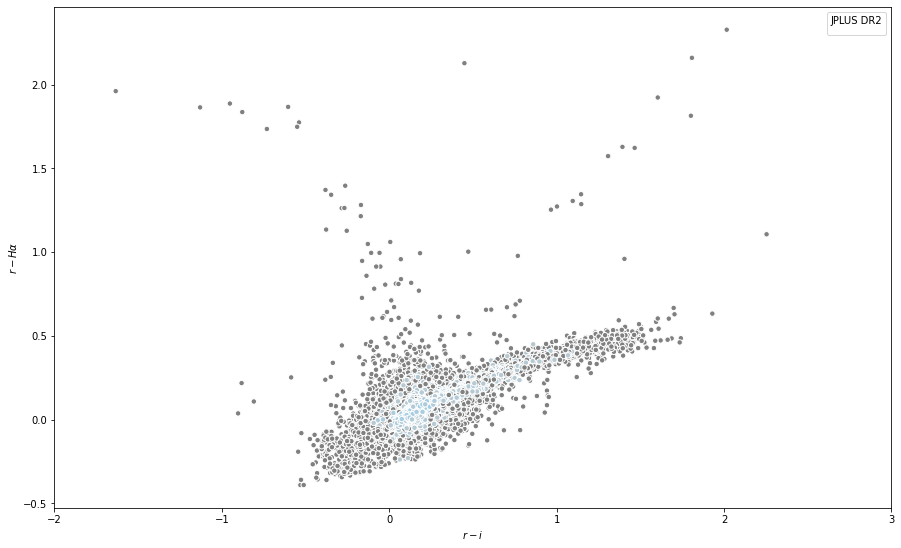

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

fig, ax = plt.subplots(figsize=(15, 15))
levels = np.array([0.001, 0.003, 0.01, 0.03, 0.1, 1.0])
GAMMA = 0.05
scatter = ax.scatter(
    r_i,
    r_ha,
    s=30,
    c=cluster_member_colors,
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="seismic",
)
ax.set(
    xlim=[-2.0, 3.0],
    #ylim=[ymin, ymax],
    xlabel=r"$r - i$",
    ylabel=r"$r - H\alpha$",
)
ax.legend(*scatter.legend_elements(), ncol=2, title="JPLUS DR2")
ax.set_aspect("equal")

Creating the tables.

In [10]:
# 1 cluster
# Mask 
mask = tab['HDBSCAN_opt_labels'] == 0
# Applying mask
tab_0 = tab[mask]

# 2 cluster
# Mask model 4 eps = 0.25
mask1 = tab['HDBSCAN_opt_labels'] == 1
# Applying mask
tab_1 = tab[mask1]

# noise
mask_noise = tab['HDBSCAN_opt_labels'] == -1
# Applying mask
tab_noise = tab[mask_noise]

print("Cluster 0 %d" % len(tab_0))
print("Cluster 1 %d" % len(tab_1))
print("Noise %d" % len(tab_noise))

Cluster 0 238494
Cluster 1 154
Noise 20813


In [11]:
from pathlib import Path
ROOT_PATH = Path("..")

In [12]:
# Save table
asciifile = "JPLUS_data_6arc-HDBcluster0.tab" 
tab_0.write(ROOT_PATH / asciifile, format="ascii.tab")

In [13]:
# Save table cluser 2
asciifile1 = "JPLUS_data_6arc-HDBcluster1.tab" 
tab_1.write(ROOT_PATH / asciifile1, format="ascii.tab")

In [14]:
# Save table Noise
asciifile2 = "JPLUS_data_6arc-HDBnoise.tab" 
tab_noise.write(ROOT_PATH / asciifile2, format="ascii.tab")

# Plotting again

In [15]:
# definition for the colors
def colour(table, f1, f2, f3, f4):
    xcolour = table[f1] - table[f2]
    ycolour = table[f3] - table[f4]
    return xcolour, ycolour

In [16]:
cx_0, cy_0 = colour(tab_0, "rSDSS_MAG_APER_6_0", "iSDSS_MAG_APER_6_0", "rSDSS_MAG_APER_6_0", "J0660_MAG_APER_6_0")
cx_1, cy_1 = colour(tab_1, "rSDSS_MAG_APER_6_0", "iSDSS_MAG_APER_6_0", "rSDSS_MAG_APER_6_0", "J0660_MAG_APER_6_0")
cx_noise, cy_noise = colour(tab_noise, "rSDSS_MAG_APER_6_0", "iSDSS_MAG_APER_6_0", "rSDSS_MAG_APER_6_0", "J0660_MAG_APER_6_0")

No handles with labels found to put in legend.


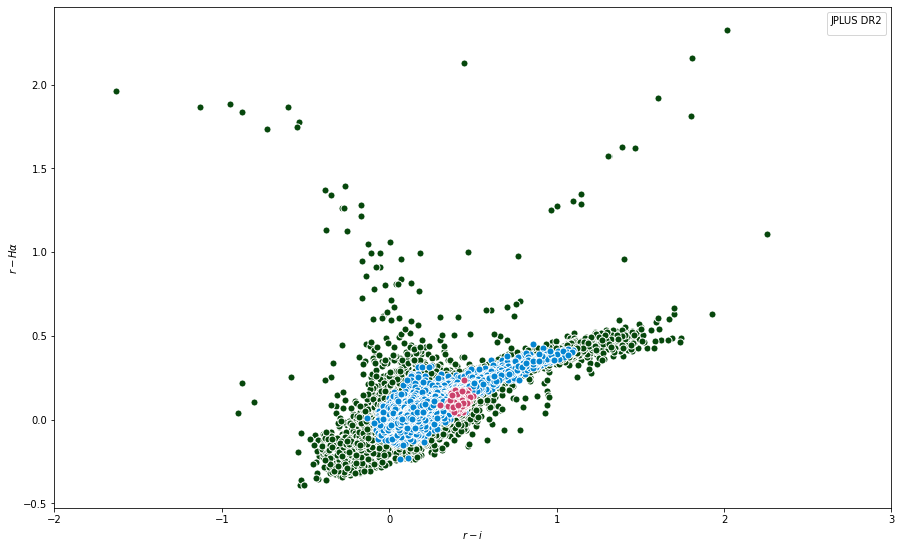

In [17]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

fig, ax1 = plt.subplots(figsize=(15, 15))
levels = np.array([0.001, 0.003, 0.01, 0.03, 0.1, 1.0])
GAMMA = 0.05
scatter = ax1.scatter(
    cx_0, cy_0,
    s=50,
    c=sns.xkcd_rgb['cerulean'],
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="seismic", zorder=2.0)
ax1.scatter(
    cx_1, cy_1,
    s=50,
    c=sns.xkcd_rgb['dark pink'],
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="seismic", zorder=3.0)
ax1.scatter(
    cx_noise, cy_noise,
    c=sns.xkcd_rgb['forest green'],
    s=50,
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="gray", zorder=1.0)
ax1.set(
    xlim=[-2.0, 3.0],
    #ylim=[ymin, ymax],
    xlabel=r"$r - i$",
    ylabel=r"$r - H\alpha$", 
)
ax1.legend(ncol=2).set_title("JPLUS DR2")
ax1.set_aspect("equal")

# Least-squares fitting to the MS and Giant locus

In [18]:
# fit a straight line to the economic data
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
 
# define the true objective function
def objective(x, a, b):
    return a * x + b

In [19]:
# curve fit
popt, _ = curve_fit(objective, cx_0, cy_0)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))

y = 0.43880 * x + -0.01927


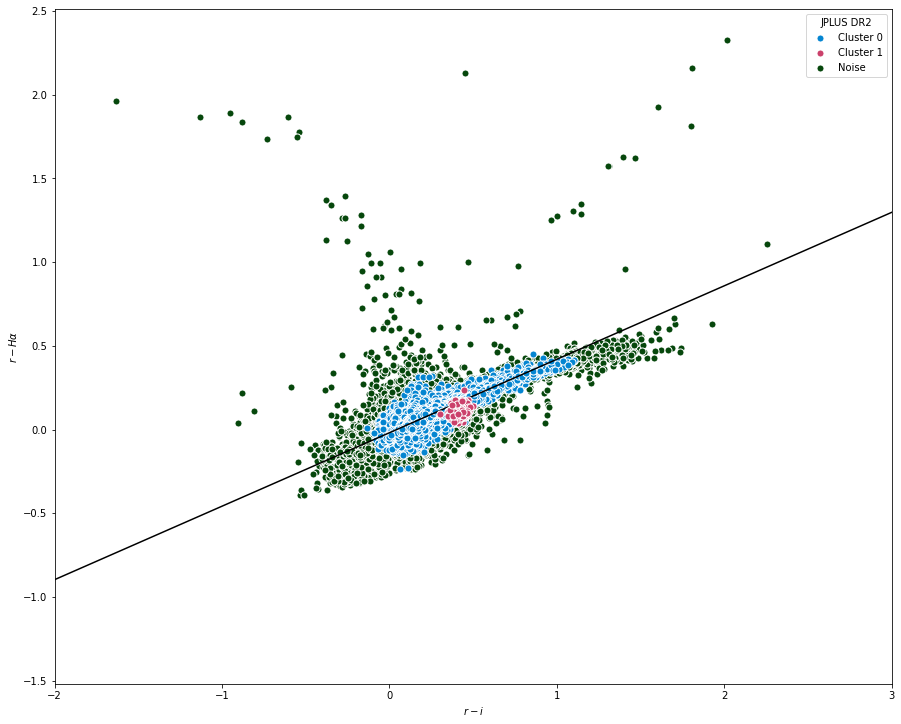

In [20]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

fig, ax2 = plt.subplots(figsize=(15, 15))

fit_line = np.linspace(-3.0, 3.0)
levels = np.array([0.001, 0.003, 0.01, 0.03, 0.1, 1.0])
GAMMA = 0.05
scatter = ax2.scatter(
    cx_0, cy_0,
    s=50,
    c=sns.xkcd_rgb['cerulean'],
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="seismic", zorder=2.0, label = "Cluster 0")
ax2.scatter(
    cx_1, cy_1,
    s=50,
    c=sns.xkcd_rgb['dark pink'],
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="seismic", zorder=3.0, label = "Cluster 1")
ax2.scatter(
    cx_noise, cy_noise,
    c=sns.xkcd_rgb['forest green'],
    s=50,
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="gray", zorder=1.0, label = "Noise")
ax2.set(
    xlim=[-2.0, 3.0],
    #ylim=[ymin, ymax],
    xlabel=r"$r - i$",
    ylabel=r"$r - H\alpha$", 
)
ax2.plot(fit_line, 0.43880 * fit_line - 0.01927, color="k")
ax2.legend(ncol=1).set_title("JPLUS DR2")
ax2.set_aspect("equal")

In [21]:
# Mask
# Choosing the objetcs in Noise list obove of the straigh line fit
mask_fit = cy_noise > 0.43880 * cx_noise - 0.01927
tab_noise_ha = tab_noise[mask_fit]

In [22]:
tab_noise_ha

Tile,Number,RA,Dec,petro_radius,kron_radius,rSDSS_MAG_APER_6_0,gSDSS_MAG_APER_6_0,iSDSS_MAG_APER_6_0,zSDSS_MAG_APER_6_0,uJAVA_MAG_APER_6_0,J0378_MAG_APER_6_0,J0395_MAG_APER_6_0,J0410_MAG_APER_6_0,J0430_MAG_APER_6_0,J0515_MAG_APER_6_0,J0660_MAG_APER_6_0,J0861_MAG_APER_6_0,rSDSS_MAG_APER_6_0_err,gSDSS_MAG_APER_6_0_err,iSDSS_MAG_APER_6_0_err,zSDSS_MAG_APER_6_0_err,uJAVA_MAG_APER_6_0_err,J0378_MAG_APER_6_0_err,J0395_MAG_APER_6_0_err,J0410_MAG_APER_6_0_err,J0430_MAG_APER_6_0_err,J0515_MAG_APER_6_0_err,J0660_MAG_APER_6_0_err,J0861_MAG_APER_6_0_err,rSDSS_FLAGS,gSDSS_FLAGS,iSDSS_FLAGS,zSDSS_FLAGS,uJAVA_FLAGS,J0378_FLAGS,J0395_FLAGS,J0410_FLAGS,J0430_FLAGS,J0515_FLAGS,J0660_FLAGS,J0861_FLAGS,rSDSS_MASK_FLAGS,gSDSS_MASK_FLAGS,iSDSS_MASK_FLAGS,zSDSS_MASK_FLAGS,uJAVA_MASK_FLAGS,J0378_MASK_FLAGS,J0395_MASK_FLAGS,J0410_MASK_FLAGS,J0430_MASK_FLAGS,J0515_MASK_FLAGS,J0660_MASK_FLAGS,J0861_MASK_FLAGS,HDBSCAN_opt_labels
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
69300,3012,181.533993206,56.4464970079,3.96000004,3.5,18.579,18.883,18.437,18.649,19.76,19.891,19.629,19.075,19.023,18.731,18.533,18.535,0.038,0.044,0.085,0.127,0.152,0.18,0.145,0.094,0.088,0.071,0.065,0.103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
69300,3014,180.038386495,56.4383294344,5.93999958,4.16863012,17.801,18.558,17.413,17.145,19.731,19.71,19.596,19.24,18.978,18.256,17.641,17.24,0.021,0.035,0.037,0.035,0.152,0.156,0.144,0.111,0.085,0.049,0.032,0.034,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
62913,6569,145.363301589,30.068638323,3.96000004,3.5,17.782,18.488,17.593,17.499,20.017,19.858,19.614,19.089,18.836,18.349,17.62,17.411,0.011,0.015,0.021,0.05,0.173,0.154,0.125,0.084,0.066,0.047,0.03,0.038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
69300,3196,182.029985903,56.4601296126,5.27999973,3.73252344,17.51,18.123,17.194,16.992,19.234,19.121,18.922,18.765,18.372,17.912,17.384,17.121,0.017,0.025,0.03,0.03,0.096,0.092,0.079,0.072,0.052,0.038,0.026,0.031,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
69300,3197,180.727314421,56.4618437895,3.5,3.5,16.231,16.155,16.434,16.441,17.518,16.749,16.293,16.123,16.126,16.111,16.334,16.437,0.007,0.006,0.017,0.019,0.025,0.015,0.012,0.011,0.01,0.011,0.012,0.018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
69300,3242,180.558291068,56.462619191,3.5,3.5,15.29,16.555,14.696,14.403,19.225,19.278,18.72,17.775,17.464,16.467,15.034,14.466,0.004,0.008,0.006,0.005,0.097,0.106,0.067,0.033,0.025,0.013,0.006,0.005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
62913,6882,145.549443782,30.0828146349,3.5,3.5,16.729,17.581,16.443,16.272,20.052,19.502,19.381,18.424,18.23,17.465,16.556,16.318,0.005,0.008,0.009,0.018,0.18,0.113,0.103,0.048,0.041,0.024,0.014,0.016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
69300,3496,181.404597629,56.4907846414,3.96000004,3.5,16.634,17.536,16.268,16.08,19.314,19.275,19.507,18.31,18.138,17.432,16.487,16.135,0.009,0.015,0.015,0.014,0.103,0.104,0.129,0.049,0.042,0.025,0.014,0.014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
69300,3567,180.869265753,56.4992705861,4.61999989,3.51735687,18.349,18.894,17.983,17.79,19.75,19.654,19.714,19.43,19.172,18.553,18.162,18.025,0.031,0.045,0.057,0.059,0.151,0.146,0.156,0.128,0.099,0.061,0.047,0.066,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1


In [23]:
cx_noise_ha, cy_noise_ha = colour(tab_noise_ha, "rSDSS_MAG_APER_6_0", "iSDSS_MAG_APER_6_0", "rSDSS_MAG_APER_6_0", "J0660_MAG_APER_6_0")

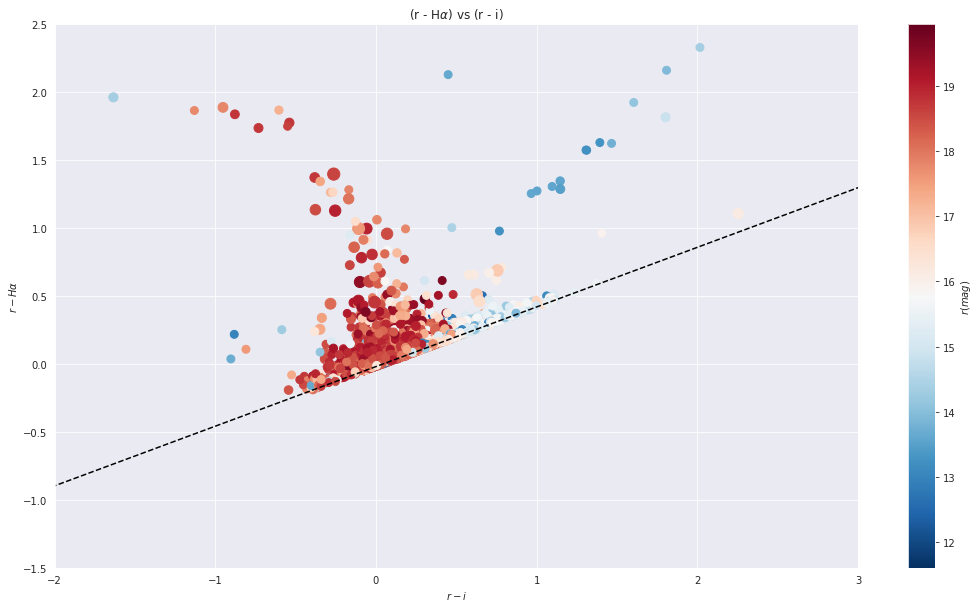

In [24]:
with sns.axes_style("darkgrid"):
    fig, ax4 = plt.subplots(figsize=(18, 10))
    scat = ax4.scatter(cx_noise_ha, cy_noise_ha, s=18*tab_noise_ha["kron_radius"], 
                             c=tab_noise_ha["rSDSS_MAG_APER_6_0"], cmap='RdBu_r')
    ax4.plot(fit_line, 0.43880 * fit_line - 0.01927, color="k", ls="--")
    ax4.set(
    xlim=[-2.0, 3.0],
    ylim=[-1.5, 2.5],
    xlabel=r"$r - i$",
    ylabel=r"$r - H\alpha$")
    fig.colorbar(scat, ax=ax4).set_label("$r(mag)$")
    #ax4.set_aspect("equal")
    ax4.set_title(r"(r - H$\alpha$) vs (r - i)")

In [26]:
# Save table
asciifile3 = "JPLUS_data_6arc-HDBnoise_Ha.tab" 
tab_noise_ha.write(ROOT_PATH / asciifile3, format="ascii.tab")

# Estimating parameter for statiscals

In [31]:
from sklearn.metrics import mean_squared_error

In [43]:
cy_noise_ha_predic = objective(cx_noise_ha, a, b)
sigma_fit = mean_squared_error(cy_noise_ha, cy_noise_ha_predic, squared=False)
print("The root mean squared value of the residuals aroundthe fit:", sigma_fit)

The root mean squared value of the residuals aroundthe fit: 0.13523455228838352
